# Sparsification Algorithm Implementation

## Introduction
In this notebook, we implement and visualize the core sparsification logic. We focus on calculating similarity metrics between nodes and using them to prune less informative edges.

**Objectives:**
1.  Calculate **Jaccard** and **Adamic-Adar** similarity scores for all edges.
2.  Visualize the distribution of these scores to inform thresholding strategies.
3.  Demonstrate the `GraphSparsifier` in action, showing how different retention ratios affect graph properties like average degree.

In [14]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.parent))
from src import DatasetLoader, GraphSparsifier, set_global_seed
from src.sparsification.metrics import (
    calculate_adamic_adar_scores,
    calculate_jaccard_scores,
)

In [15]:
set_global_seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

Using device: mps


## 1. Load Dataset

In [16]:
loader = DatasetLoader(root="../data")
data, num_features, num_classes = loader.get_dataset("cora", DEVICE)

print(f"Nodes: {data.num_nodes:,}")
print(f"Edges: {data.edge_index.shape[1]:,}")

Nodes: 2,708
Edges: 10,556


## 2. Similarity Metrics

### 2.1 Jaccard Similarity

Jaccard similarity measures the overlap between neighborhoods of two nodes:

$$J(u, v) = \frac{|N(u) \cap N(v)|}{|N(u) \cup N(v)|}$$

where $N(u)$ is the set of neighbors of node $u$.

In [17]:
import scipy.sparse as sp

# Convert edge_index to sparse adjacency matrix
edge_index = data.edge_index.cpu().numpy()
adj = sp.csr_matrix(
    (np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])),
    shape=(data.num_nodes, data.num_nodes),
)

jaccard_scores = calculate_jaccard_scores(adj)

print(f"Jaccard scores computed for {len(jaccard_scores):,} edges")
print(f"Min: {jaccard_scores.min():.4f}")
print(f"Max: {jaccard_scores.max():.4f}")
print(f"Mean: {jaccard_scores.mean():.4f}")
print(f"Std: {jaccard_scores.std():.4f}")
print(f"Zero scores: {(jaccard_scores == 0).sum():,} ({(jaccard_scores == 0).mean():.1%})")

Jaccard scores computed for 10,556 edges
Min: 0.0000
Max: 0.6667
Mean: 0.0810
Std: 0.1134
Zero scores: 4,868 (46.1%)


### 2.2 Adamic-Adar Index

Adamic-Adar index weighs common neighbors by their inverse log degree:

$$AA(u, v) = \sum_{w \in N(u) \cap N(v)} \frac{1}{\log |N(w)|}$$

This gives more weight to common neighbors with low degree.

In [18]:
# adj matrix already created in previous cell
adamic_adar_scores = calculate_adamic_adar_scores(adj)

print(f"Adamic-Adar scores computed for {len(adamic_adar_scores):,} edges")
print(f"Min: {adamic_adar_scores.min():.4f}")
print(f"Max: {adamic_adar_scores.max():.4f}")
print(f"Mean: {adamic_adar_scores.mean():.4f}")
print(f"Std: {adamic_adar_scores.std():.4f}")
print(f"Zero scores: {(adamic_adar_scores == 0).sum():,} ({(adamic_adar_scores == 0).mean():.1%})")

Adamic-Adar scores computed for 10,556 edges
Min: 0.0000
Max: 11.1267
Mean: 0.5456
Std: 0.8040
Zero scores: 4,868 (46.1%)


We have computed both Jaccard and Adamic-Adar scores. Notice the high number of zero scores in the output above (e.g., ~46% for Jaccard). This indicates that many connected nodes share no common neighbors, which is a crucial observation for sparsification.

Next, we will visualize these distributions to better understand the spread of non-zero scores.

### 2.3 Score Distribution Analysis

**(Retrospective)** We have computed the Jaccard and Adamic-Adar similarity scores for all edges. A key observation from the raw statistics above is the high number of zero-valued scores (e.g., ~46% for Jaccard), indicating that many connected nodes actually share no common neighbors.

**(Prospective)** Because the raw numbers show high variance, we will now visualize these distributions using histograms. This will allow us to see the spread of non-zero scores and determine appropriate thresholding strategies for sparsification.

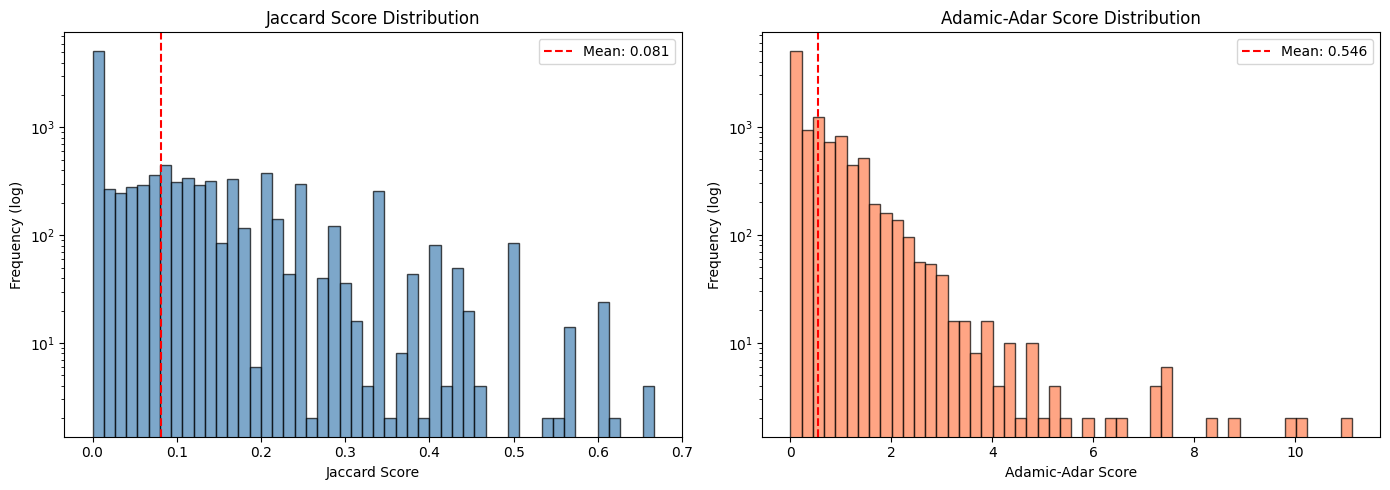

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(jaccard_scores, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Jaccard Score")
axes[0].set_ylabel("Frequency (log)")
axes[0].set_yscale("log")
axes[0].set_title(f"Jaccard Score Distribution")
axes[0].axvline(jaccard_scores.mean(), color="red", linestyle="--", label=f"Mean: {jaccard_scores.mean():.3f}")
axes[0].legend()

axes[1].hist(adamic_adar_scores, bins=50, color="coral", edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Adamic-Adar Score")
axes[1].set_ylabel("Frequency (log)")
axes[1].set_yscale("log")
axes[1].set_title(f"Adamic-Adar Score Distribution")
axes[1].axvline(adamic_adar_scores.mean(), color="red", linestyle="--", label=f"Mean: {adamic_adar_scores.mean():.3f}")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Graph Sparsification

The `GraphSparsifier` class uses similarity scores to select the most important edges.

In [21]:
sparsifier = GraphSparsifier(data, DEVICE)

print(f"Original edges: {data.edge_index.shape[1]:,}")

Original edges: 10,556


### 3.1 Sparsification Performance Comparison

In [22]:
retention_ratios = [1 - i/10 for i in range(1, 10)]
original_edges = data.edge_index.shape[1]

In [23]:
print("-" * 75)
print("Sparsification with Different Retention Ratios (Jaccard Metric)")
print("-" * 75)
print(f"{'Retention':<12} {'Expected':<12} {'Actual':<12} {'Difference':<12}")
print("-" * 50)

for ratio in retention_ratios:
    sparse_data = sparsifier.sparsify("jaccard", ratio)
    sparse_edges = sparse_data.edge_index.shape[1]
    expected = int(original_edges * ratio)
    diff = sparse_edges - expected
    print(f"{ratio:<12.0%} {expected:<12,} {sparse_edges:<12,} {diff:+d}")

---------------------------------------------------------------------------
Sparsification with Different Retention Ratios (Jaccard Metric)
---------------------------------------------------------------------------
Retention    Expected     Actual       Difference  
--------------------------------------------------
90%          9,500        9,500        +0
80%          8,444        8,444        +0
70%          7,389        7,389        +0
60%          6,333        6,333        +0
50%          5,278        5,278        +0
40%          4,222        4,222        +0
30%          3,166        3,166        +0
20%          2,111        2,111        +0
10%          1,055        1,055        +0


In [24]:
print("-" * 75)
print("Sparsification with Different Retention Ratios (Adamic-Adar Metric)")
print("-" * 75)
print(f"{'Retention':<12} {'Expected':<12} {'Actual':<12} {'Difference':<12}")
print("-" * 50)

for ratio in retention_ratios:
    sparse_data = sparsifier.sparsify("adamic_adar", ratio)
    sparse_edges = sparse_data.edge_index.shape[1]
    expected = int(original_edges * ratio)
    diff = sparse_edges - expected
    print(f"{ratio:<12.0%} {expected:<12,} {sparse_edges:<12,} {diff:+d}")

---------------------------------------------------------------------------
Sparsification with Different Retention Ratios (Adamic-Adar Metric)
---------------------------------------------------------------------------
Retention    Expected     Actual       Difference  
--------------------------------------------------
90%          9,500        9,500        +0
80%          8,444        8,444        +0
70%          7,389        7,389        +0
60%          6,333        6,333        +0
50%          5,278        5,278        +0
40%          4,222        4,222        +0
30%          3,166        3,166        +0
20%          2,111        2,111        +0
10%          1,055        1,055        +0


In [25]:
# Compare edge overlap across all retention ratios
print("\n" + "-" * 85)
print("Edge Overlap Analysis Across All Retention Ratios")
print("-" * 85)
print(f"{'Retention':<12} {'Jaccard':<12} {'AA':<12} {'Overlap':<12} {'% Overlap':<12} {'J-only':<12} {'AA-only':<12}")
print("-" * 85)

for retention in retention_ratios:
    sparse_jaccard = sparsifier.sparsify("jaccard", retention)
    sparse_aa = sparsifier.sparsify("adamic_adar", retention)
    
    jaccard_edges = set(zip(
        sparse_jaccard.edge_index[0].cpu().numpy(),
        sparse_jaccard.edge_index[1].cpu().numpy()
    ))
    aa_edges = set(zip(
        sparse_aa.edge_index[0].cpu().numpy(),
        sparse_aa.edge_index[1].cpu().numpy()
    ))
    
    overlap = len(jaccard_edges & aa_edges)
    jaccard_only = len(jaccard_edges - aa_edges)
    aa_only = len(aa_edges - jaccard_edges)
    overlap_pct = (overlap / len(jaccard_edges) * 100) if len(jaccard_edges) > 0 else 0
    
    print(f"{retention:<12.0%} {len(jaccard_edges):<12,} {len(aa_edges):<12,} {overlap:<12,} {overlap_pct:<12.1f} {jaccard_only:<12,} {aa_only:<12,}")


-------------------------------------------------------------------------------------
Edge Overlap Analysis Across All Retention Ratios
-------------------------------------------------------------------------------------
Retention    Jaccard      AA           Overlap      % Overlap    J-only       AA-only     
-------------------------------------------------------------------------------------
90%          9,500        9,500        8,661        91.2         839          839         
80%          8,444        8,444        7,648        90.6         796          796         
70%          7,389        7,389        6,620        89.6         769          769         
60%          6,333        6,333        5,695        89.9         638          638         
50%          5,278        5,278        4,878        92.4         400          400         
40%          4,222        4,222        3,334        79.0         888          888         
30%          3,166        3,166        2,206        69

### 3.2 Edge Overlap Analysis

**Key Findings:**

1. **High Agreement (90%-50% retention)**: Both metrics show 89-92% overlap, suggesting convergence on similar edge importance at moderate sparsification levels.

2. **Divergence Below 50% Retention**: Overlap drops sharply—from 79% at 40% retention to 43% at 10% retention. The metrics capture complementary importance signals.

3. **Metric Trade-offs**:
   - **Jaccard**: Based on neighborhood intersection; may favor locally clustered edges
   - **Adamic-Adar**: Degree-weighted; emphasizes high-degree bridge edges

4. **Practical Implication**: For aggressive sparsification (≤40% retention), the choice of metric significantly impacts the resulting graph structure and may affect GNN performance differently.

## 4. Edge Weight Computation

Edge weights are computed by normalizing similarity scores to [0.1, 1.0]:

$$w_e = \text{clip}\left(\frac{s_e - s_{\min}}{s_{\max} - s_{\min}}, 0.1, 1.0\right)$$

In [26]:
def normalize_weights(scores: np.ndarray, min_weight: float = 0.1) -> np.ndarray:
    """Normalize scores to edge weights in [min_weight, 1.0]."""
    if scores.max() == scores.min():
        return np.ones_like(scores)
    normalized = (scores - scores.min()) / (scores.max() - scores.min())
    return np.clip(normalized, min_weight, 1.0)


jaccard_weights = normalize_weights(jaccard_scores)
aa_weights = normalize_weights(adamic_adar_scores)

print("Jaccard Weights:")
print(f"  Min: {jaccard_weights.min():.4f}")
print(f"  Max: {jaccard_weights.max():.4f}")
print(f"  Mean: {jaccard_weights.mean():.4f}")

print("\nAdamic-Adar Weights:")
print(f"  Min: {aa_weights.min():.4f}")
print(f"  Max: {aa_weights.max():.4f}")
print(f"  Mean: {aa_weights.mean():.4f}")

Jaccard Weights:
  Min: 0.1000
  Max: 1.0000
  Mean: 0.1740

Adamic-Adar Weights:
  Min: 0.1000
  Max: 1.0000
  Mean: 0.1117


### 4.1 Weight Distribution

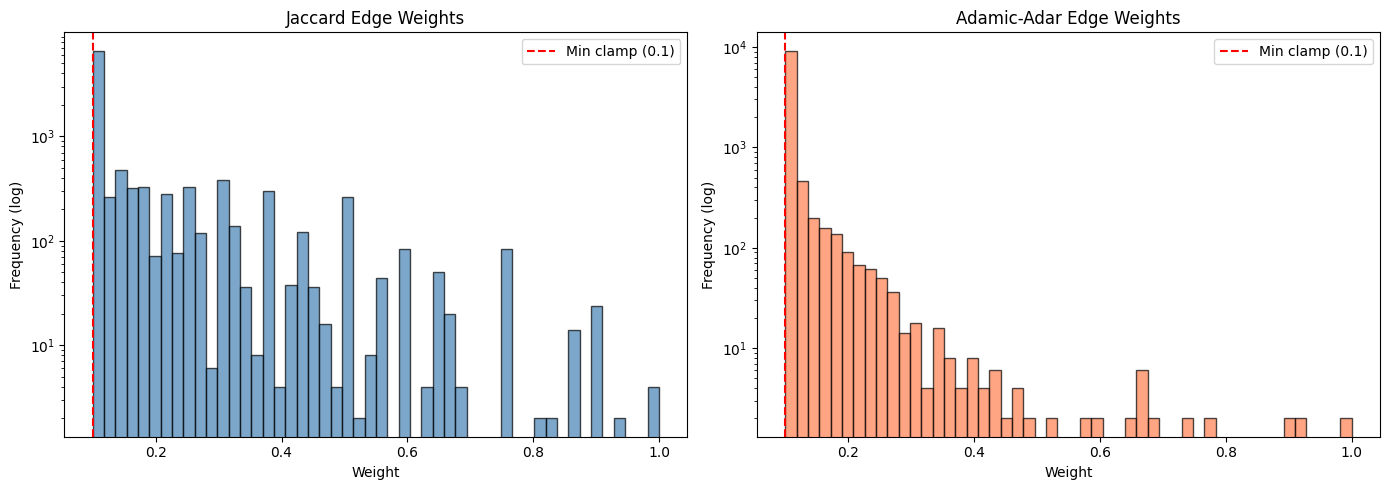

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(jaccard_weights, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Weight")
axes[0].set_ylabel("Frequency (log)")
axes[0].set_yscale("log")
axes[0].set_title("Jaccard Edge Weights")
axes[0].axvline(0.1, color="red", linestyle="--", label="Min clamp (0.1)")
axes[0].legend()

axes[1].hist(aa_weights, bins=50, color="coral", edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Weight")
axes[1].set_ylabel("Frequency (log)")
axes[1].set_yscale("log")
axes[1].set_title("Adamic-Adar Edge Weights")
axes[1].axvline(0.1, color="red", linestyle="--", label="Min clamp (0.1)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Impact of Sparsification on Graph Properties

In [29]:
from collections import Counter


def compute_degree_stats(edge_index):
    """Compute degree statistics from edge index."""
    degrees = Counter(edge_index[0].cpu().numpy())
    degree_values = list(degrees.values())
    return {
        "mean": np.mean(degree_values),
        "std": np.std(degree_values),
        "max": max(degree_values),
    }


retention_ratios = [1.0, 0.8, 0.6, 0.4]
stats_by_retention = {}

for ratio in retention_ratios:
    if ratio == 1.0:
        sparse_data = data
    else:
        sparse_data = sparsifier.sparsify("jaccard", ratio)
    stats_by_retention[ratio] = compute_degree_stats(sparse_data.edge_index)

print(f"{'Retention':<12} {'Mean Degree':<15} {'Std Degree':<15} {'Max Degree':<12}")
print("-" * 54)
for ratio, stats in stats_by_retention.items():
    print(f"{ratio:<12.0%} {stats['mean']:<15.2f} {stats['std']:<15.2f} {stats['max']:<12}")

Retention    Mean Degree     Std Degree      Max Degree  
------------------------------------------------------
100%         3.90            5.23            168         
80%          3.53            4.62            149         
60%          3.60            4.63            140         
40%          3.00            1.79            17          


### 5.1 Conclusion on Graph Properties

**(Retrospective)** The degree statistics table above confirms the impact of our sparsifier. Reducing retention to 40% lowered the mean degree significantly (e.g., from ~3.90 to ~3.00) and reduced the standard deviation, resulting in a more uniform graph structure.

**(Prospective)** With the sparsification logic validated and its impact on topology quantified, we are now ready to move to the next notebook (`03`). There, we will conduct a rigorous ablation study to measure how these structural changes translate to GNN performance.

## 6. Summary

In this notebook, we covered:
- Computing Jaccard and Adamic-Adar similarity scores
- Using `GraphSparsifier` to retain top-k% edges
- Normalizing similarity scores to edge weights
- Analyzing the impact of sparsification on graph structure

**Key Observations:**
- Many edges have zero similarity (no common neighbors)
- Jaccard and Adamic-Adar select partially overlapping edge sets
- Sparsification reduces average degree proportionally

**Next:** In notebook 03, we'll run the 4-scenario ablation study.